# Customer Service Flow Analysis 

## Background

All of the data seen below is for the client SharkNinja. They recently launched 5 new flows that presumably survey clients in 5 distinct countries about their customer service experience. 

## Objective

This analysis strives to better understand the flows, when they started, how they have preformed over time, and what they look like from a user's perspective. 

In [2]:
import sys
sys.path.append("..")

import os
from google.cloud import bigquery
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from src import SankeyFlow




credential_path = "/home/kerri/bigquery-jaya-consultant-cosmic-octane-88917-c46ba9b53a3b.json"
assert os.path.exists(credential_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
project_id = 'cosmic-octane-88917'
client = bigquery.Client(project=project_id)

In [6]:
sql_temp = """
WITH major_events AS (
SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'API_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_ApiEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'CALL_EVENT', ':', CallAnswerIndicator) AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_CallEvent`
WHERE ActionId != 'TRANSFER_33'

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', CAST(DtmfInput AS STRING), '-dtmf') ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_DtmfEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'MSG_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_MsgEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'NLP_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_NlpEvent`

/*
UNION ALL 


SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'EXIT_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_ApplicationExitEvent`

UNION ALL 


SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'RECORD_EVENT'),
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_CallDetailRecordEvent`
*/

),

filtered AS (
SELECT  SessionId,
        TimeStamp,
        ActionId,
        FlowName
FROM major_events
WHERE 
FlowName in {0}
AND EXTRACT(DATE FROM TimeStamp) BETWEEN '{1}' AND '{2}'
),

metric_prep AS (
SELECT 
       SessionId,
       ActionId,
       TimeStamp,
       ROW_NUMBER() OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS rank_event,
       FIRST_VALUE(TimeStamp) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS first_value,
       LEAD(TimeStamp) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS next_value,
       LEAD(ActionId) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS next_event,
       FlowName,
       
FROM
filtered
)

SELECT
       SessionId AS user_id,
       ActionId  AS event_name,
       TimeStamp AS time_event,
       rank_event,
       next_event,
       FlowName,
       TIMESTAMP_DIFF(TimeStamp, first_value, SECOND) AS time_from_start,
       TIMESTAMP_DIFF(next_value, TimeStamp, SECOND) AS time_to_next
FROM metric_prep
--WHERE ActionId NOT LIKE '%END_CALL%'
ORDER BY user_id, time_event
--LIMIT 100000
"""


In [2]:
sql_time_evol = """
WITH count_steps AS (
SELECT
        TimeStamp,
        SessionId,
        FlowName,
        CHARACTER_LENGTH(Path) - CHARACTER_LENGTH(REPLACE(Path, ';', '')) AS pathLength
FROM `cosmic-octane-88917.analytics_us._VW_ApplicationExitEvent`
),

calc_values AS (
SELECT 
      EXTRACT(DATE FROM TimeStamp) AS date,
      COUNT(DISTINCT(SessionId)) AS count,
      AVG(pathLength) AS avg_pathLength,
      FlowName
FROM count_steps
WHERE FlowName in {0}
GROUP BY date, FlowName

)

SELECT *,
      AVG(count) OVER(PARTITION BY FlowName ORDER BY date 
                 ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) AS avg_14_day_count,
      AVG(avg_pathLength) OVER(PARTITION BY FlowName ORDER BY date 
                 ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) AS avg_14_day_pathLength
FROM calc_values

"""


In [3]:


def time_stats(flownames, hue):
    
    q = sql_time_evol.format(flownames)
    df = client.query(q).to_dataframe()
    
    fig, (ax1,ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15,30))
    chart = sns.lineplot(x="date", y="avg_14_day_count",
                 hue=hue, 
                 data=df, ax=ax1)
    chart.set_title(f"14 Day Rolling Average Count")


    chart = sns.lineplot(x="date", y="avg_14_day_pathLength",
                 hue=hue, 
                 data=df, ax=ax2)
    chart.set_title(f"14 Day Rolling Avg Path Length")


    chart = sns.lineplot(x="date", y="count",
                 hue=hue, 
                 data=df, ax=ax3)
    chart.set_title(f"Count")


    chart = sns.lineplot(x="date", y="avg_pathLength",
                 hue=hue, 
                 data=df, ax=ax4)
    chart.set_title(f"Path Length")

In [4]:
flows = ["United Kingdom - Customer Service", 
         "Italy - Customer Service",
         "France - Customer Service",
         "Spain - Customer Service",
         "Germany - Customer Service"]
time_stats(tuple(flows), 'FlowName')

NameError: name 'client' is not defined

# Preformance Over Time

The plots compare the 5 flows over two dimensions. 

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

### Takeaways

- United Kingdom has a much higher volume than the other flows
- United Kingdom has a higher and more stable average path length
- Path lengths differ between weekdays and weekend, probably because SharkNinja is not taking calls on weekends
- The total count of people calling in on weekends is also smaller
- While path lenght for United Kingdom and Germany became stable around June Italy, France, and Spain did not really level out until September.

/home/kerri/Documents/Projects/intelepeer/sharkninja_analysis/venv8/lib/python3.8/site-packages/google/cloud/bigquery/client.py:439: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


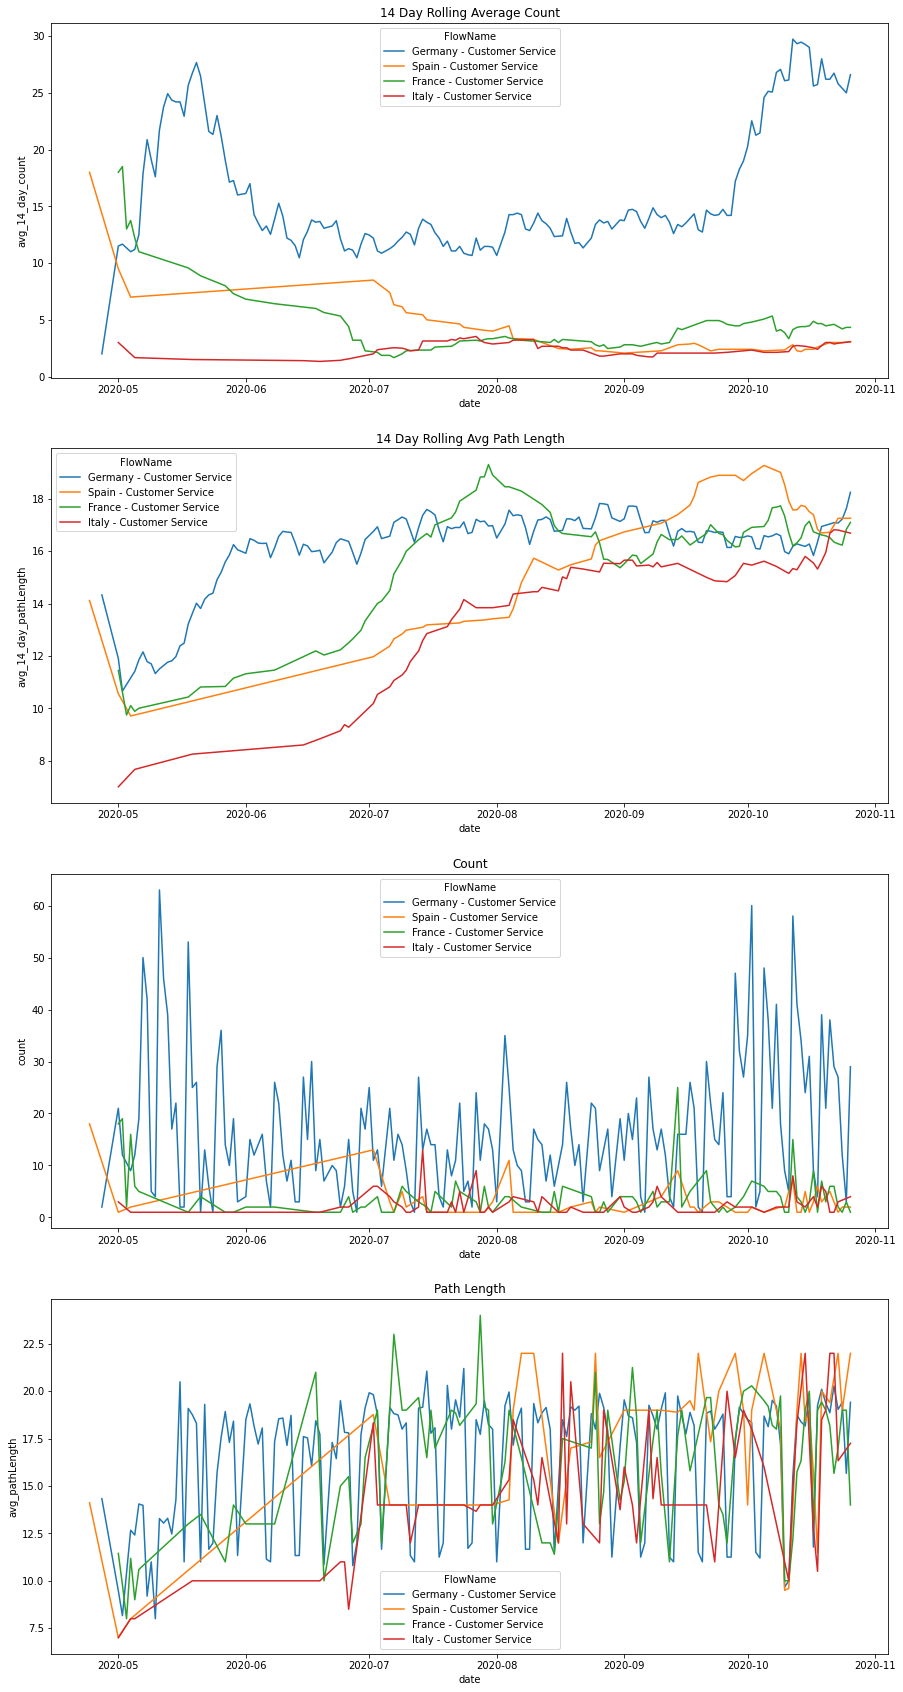

In [6]:
flows_wo_uk = [
         "Italy - Customer Service",
         "France - Customer Service",
         "Spain - Customer Service",
         "Germany - Customer Service"]
time_stats(tuple(flows_wo_uk), 'FlowName')

# Preformance Over Time - UK Removed

The plots compare the 4 flows over two dimensions. The UK was remove so as to not drawf the other flows

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

### Takeaways

- Germany has the second highest volume of calls
- Germany saw a spike in the month of October
- Other flows have consistently less than 5 calls

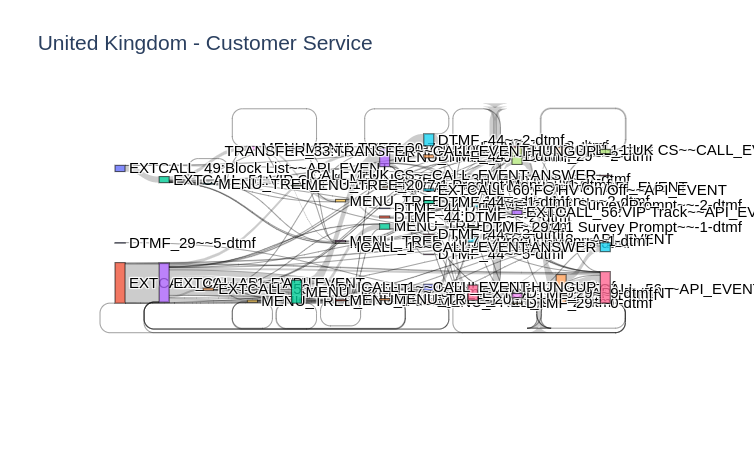

In [17]:
FlowName =  "United Kingdom - Customer Service"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
uk_flow = SankeyFlow(FlowName, df)
uk_flow.plot(100, FlowName).show()

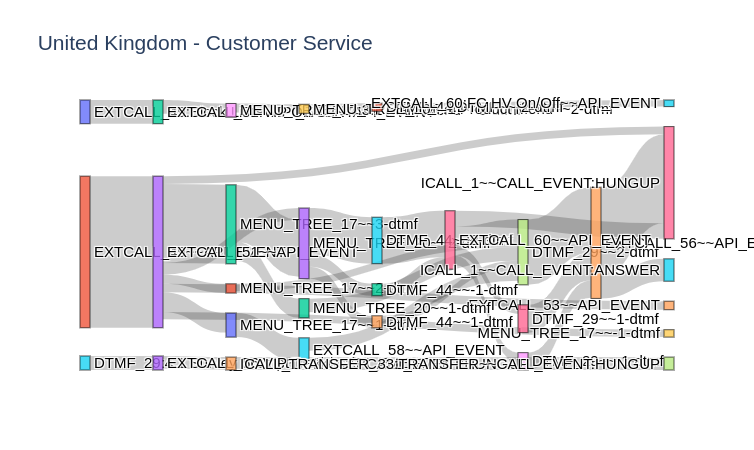

In [18]:
uk_flow.modify_threshold(12000).show()

## United Kingdom - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 12000 users. 

### Takeaways
- There appears to be two main enterances to the flow, 1) the EXTCALL_51 API_EVENT or a small flow that includes a VIP track
- The paths from the two entrances are always seperate, it's to say they do not share any nodes
- Taking that thought a step further, the two VIP tracks don't share nodes either
- The most popular flow is:
MENU_TREE_17-Option3 -> MENU_TREE_2-Option2 -> DTMF_44-Option2 -> DTMF_29-Option2

- Call events labeled as ANSWERED last on average about 1.25 minutes longer than those labeled HANGUP
- Users save about 10 seconds when they skip the MENU_TREE_17
- Users save about 22 seconds when they choose MENU_TREE_20-Option1 over MENU_TREE_20-Option2
- MENU_TREE_17-Option2 is about 41 seconds faster than MENU_TREE_17-Option3
- MENU_TREE_17-Option1 is about 19 seconds faster than MENU_TREE_17-Option3
- The majority of usesrs end in ICALL_1:HANGUP

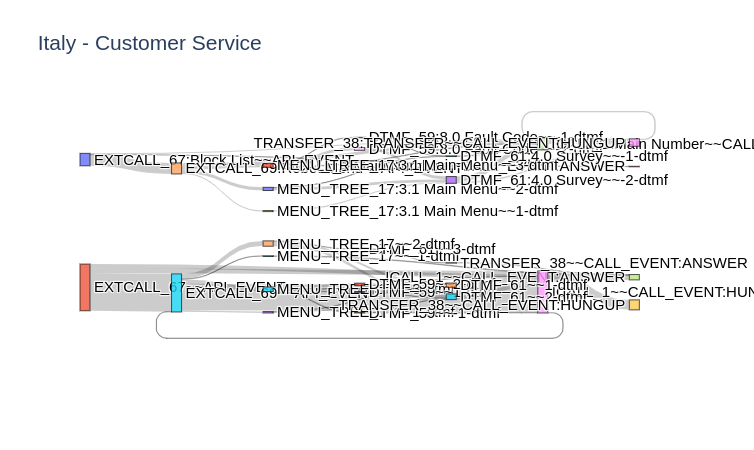

In [19]:
FlowName = "Italy - Customer Service"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
it_flow = SankeyFlow(FlowName, df)
it_flow.plot(0, FlowName).show()

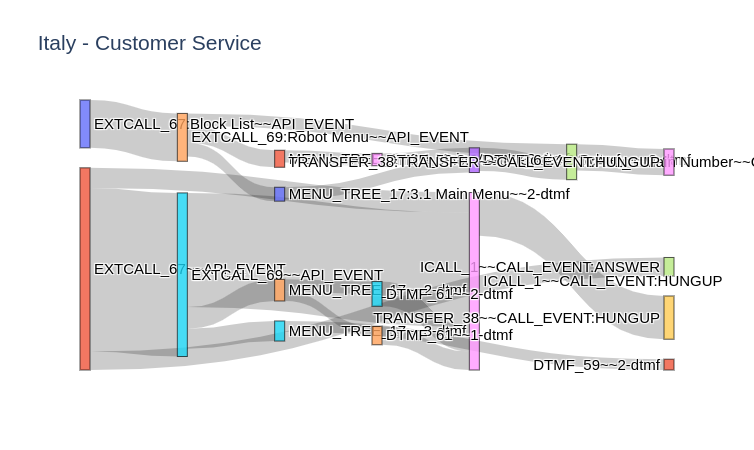

In [20]:
it_flow.modify_threshold(5).show()

## Italy - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 5 users.

## Takeaways
- There exists two independent flows 
- The majority (115) of users do not go through any of the menues but instead pass directly to ICALL_1:HANGUP

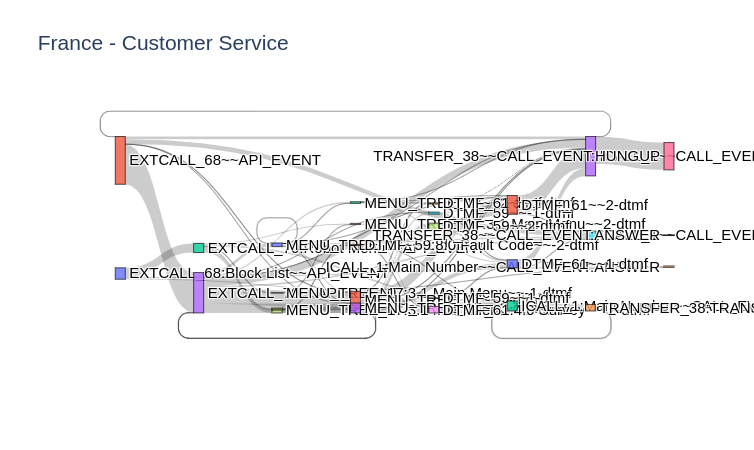

In [21]:
FlowName = "France - Customer Service"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
fr_flow = SankeyFlow(FlowName, df)
fr_flow.plot(0, FlowName).show()

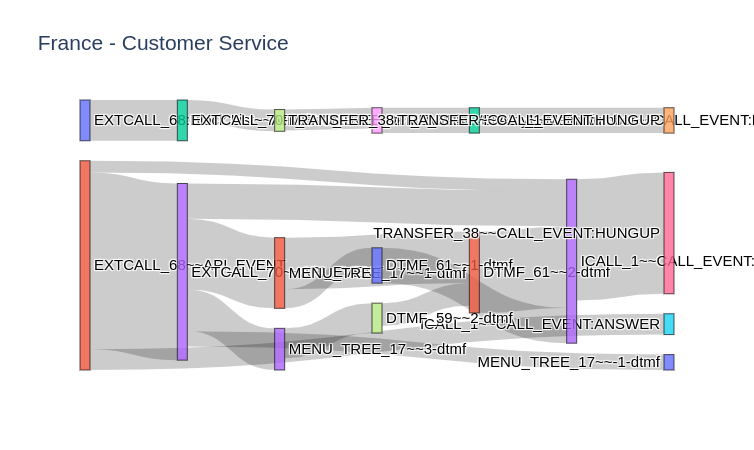

In [22]:
fr_flow.modify_threshold(10).show()

## France - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 10 users.

## Takeaways
- Two independent flows
- Most common path is to ICALL_1:HANGUP
- MENU_TREE_17-Option1 is about 20 seconds faster than MEMU_TREE_17-Option3
- Almost all ICALL_1:ANSWER event come from the initial API_EVENT
- The average user that moved through DTMF_61-Option1 was on average 23 seconds faster than a users that moved through other menus

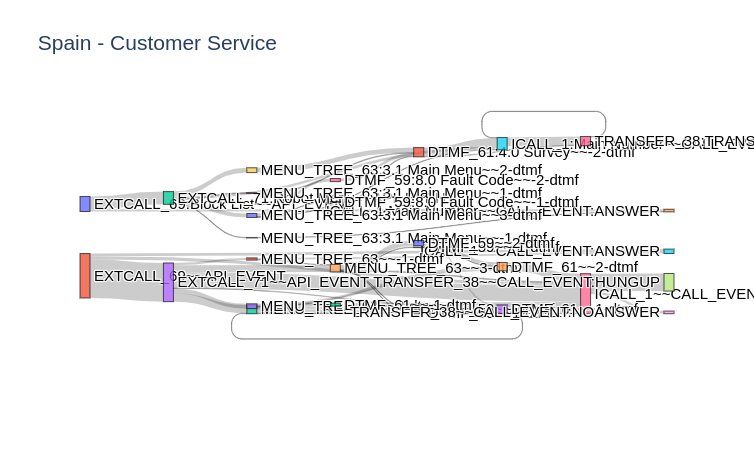

In [23]:
FlowName = "Spain - Customer Service"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
es_flow = SankeyFlow(FlowName, df)
es_flow.plot(0, FlowName).show()

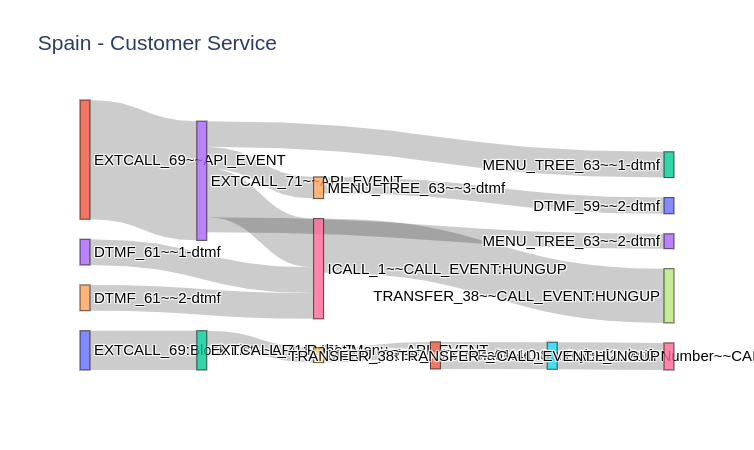

In [24]:
es_flow.modify_threshold(10).show()

## Spain - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 10 users.

## Takeaways
- Two independent flows
- Several users enter through DTMF_61 and move directly to ICALL_1:HANGUP
- The Block_list flow appears to take a user on average 3 minutes longer


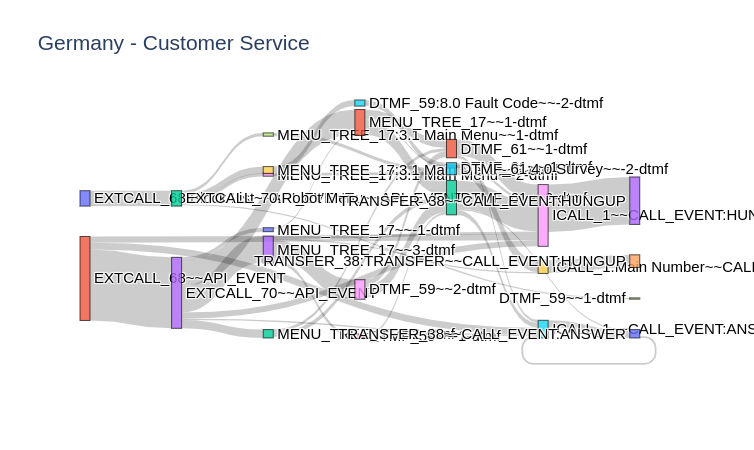

In [25]:
FlowName = "Germany - Customer Service"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
gr_flow = SankeyFlow(FlowName, df)
gr_flow.plot(25, FlowName).show()

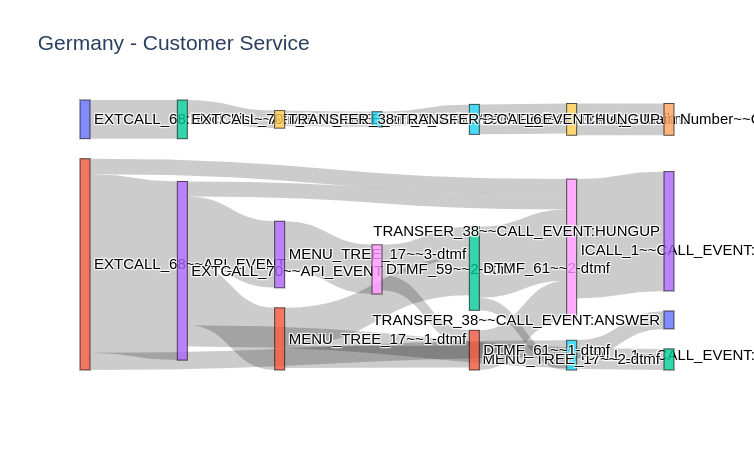

In [26]:
gr_flow.modify_threshold(100).show()

## Germany - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 100 users.

## Takeaways
- Two independent flows
- MENU_TREE_17-Option1 is about 20 seconds faster than MENU_TREE_17-Option3
- The users are split almost 50:50 between MENU_TREE_17-Option1 and Option3 (587 and 545 respectivly)
- The majority of users end in ICALL_1:HANGUP
- The smaller of the two flows takes an average user 3 minutes less time than the normal flow

# OTHER FLOWS

The following are other SharkNinja flows that don't necessarily follows the "Customer Service" pattern

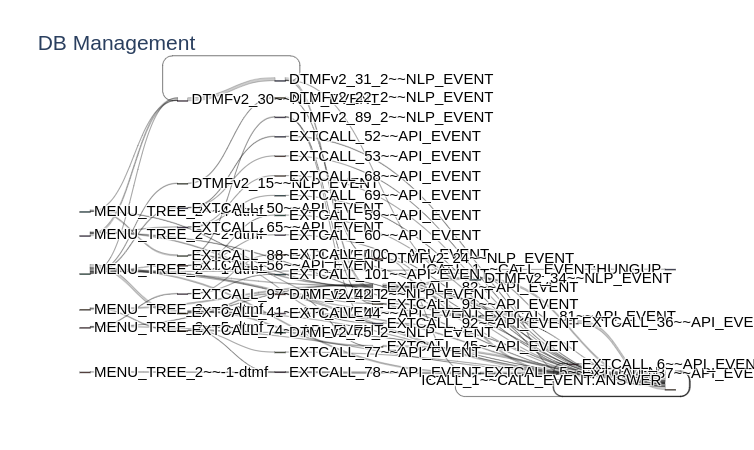

In [43]:
FlowName = "DB Management"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
DB_flow = SankeyFlow(FlowName, df)
DB_flow.plot(0, FlowName).show()

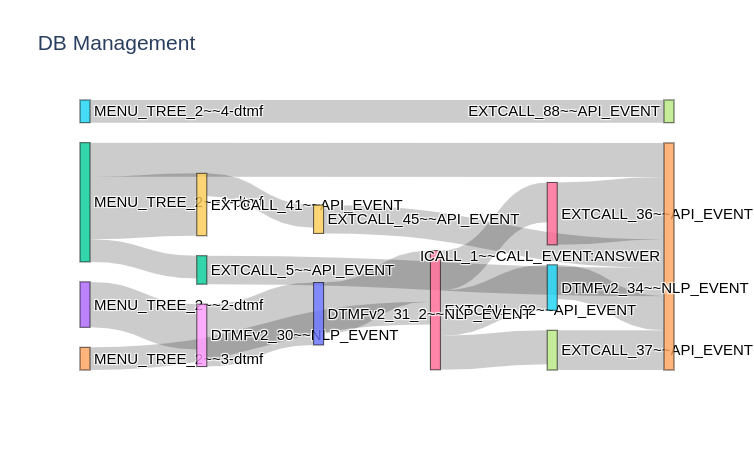

In [44]:
DB_flow.modify_threshold(4).show()

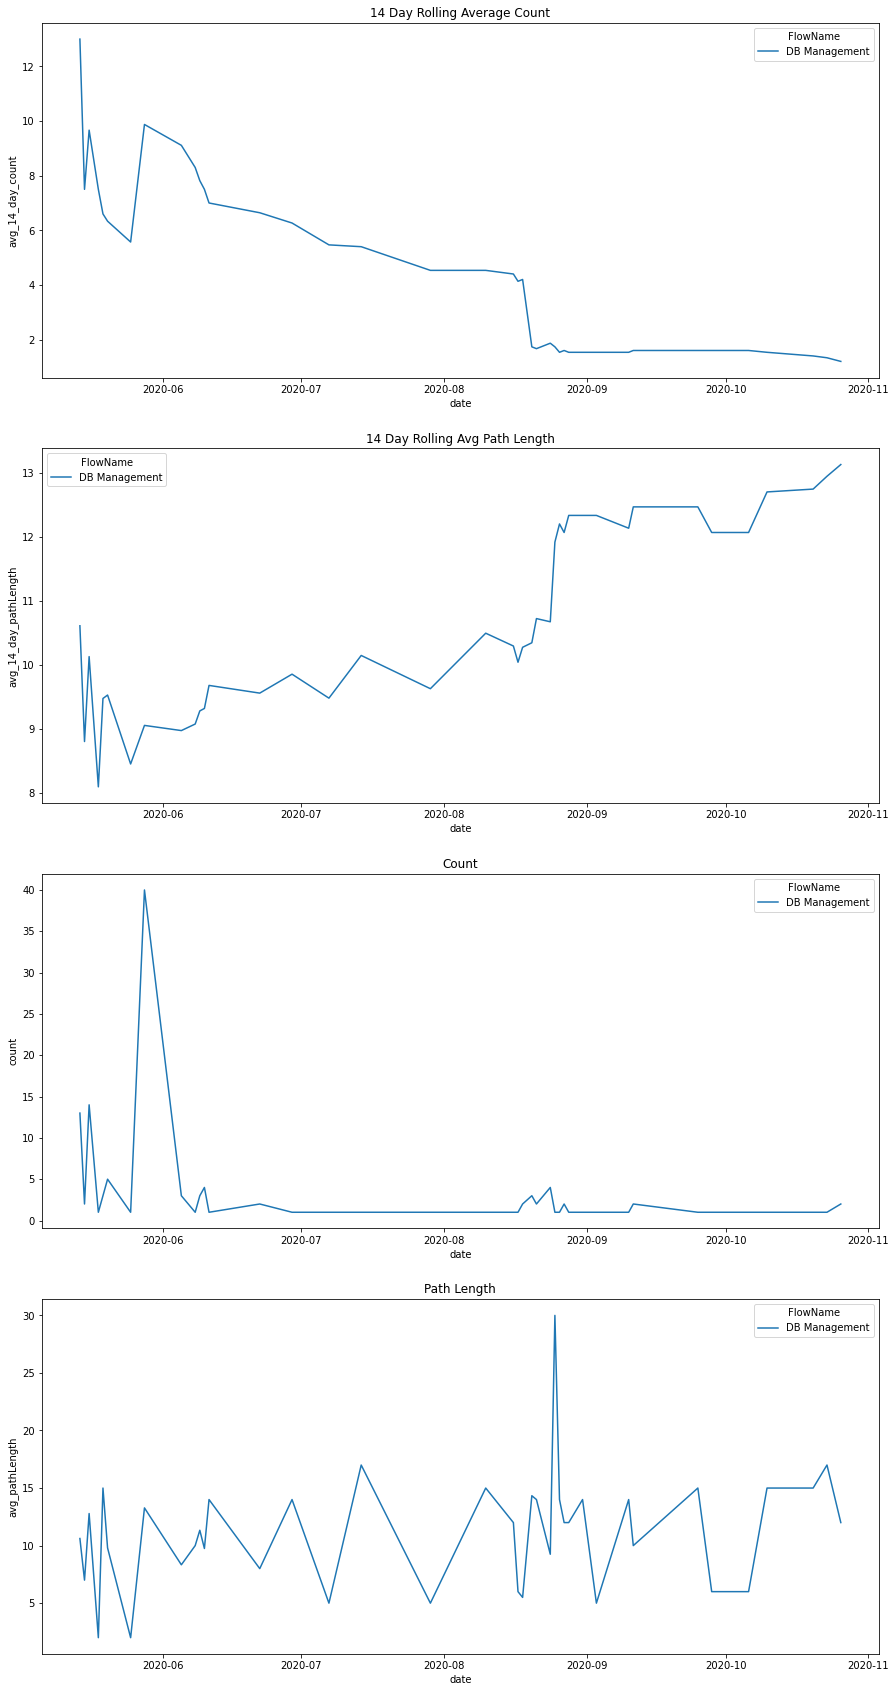

In [29]:
time_stats(f"('{FlowName}')", 'FlowName')

## DB Management

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. The lower plot shows a trimmed version with only those paths that have over 10 users.

## Takeaways
- Very low volume, a total of 5 users entering the MENU_TREE_2
- 4 out of 5 users ended in ICALL_1:ANSWER

/home/kerri/Documents/Projects/intelepeer/sharkninja_analysis/venv8/lib/python3.8/site-packages/google/cloud/bigquery/client.py:439: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



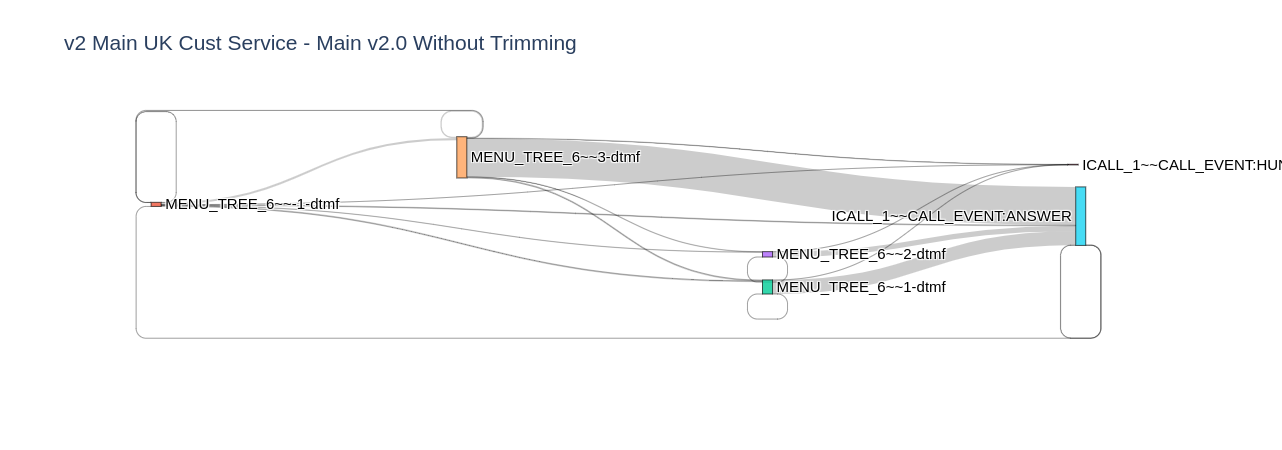

In [30]:
FlowName = "v2 Main UK Cust Service - Main v2.0"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
v2_main_flow = SankeyFlow(FlowName, df)
v2_main_flow.plot(0, f"{FlowName} Without Trimming").show()

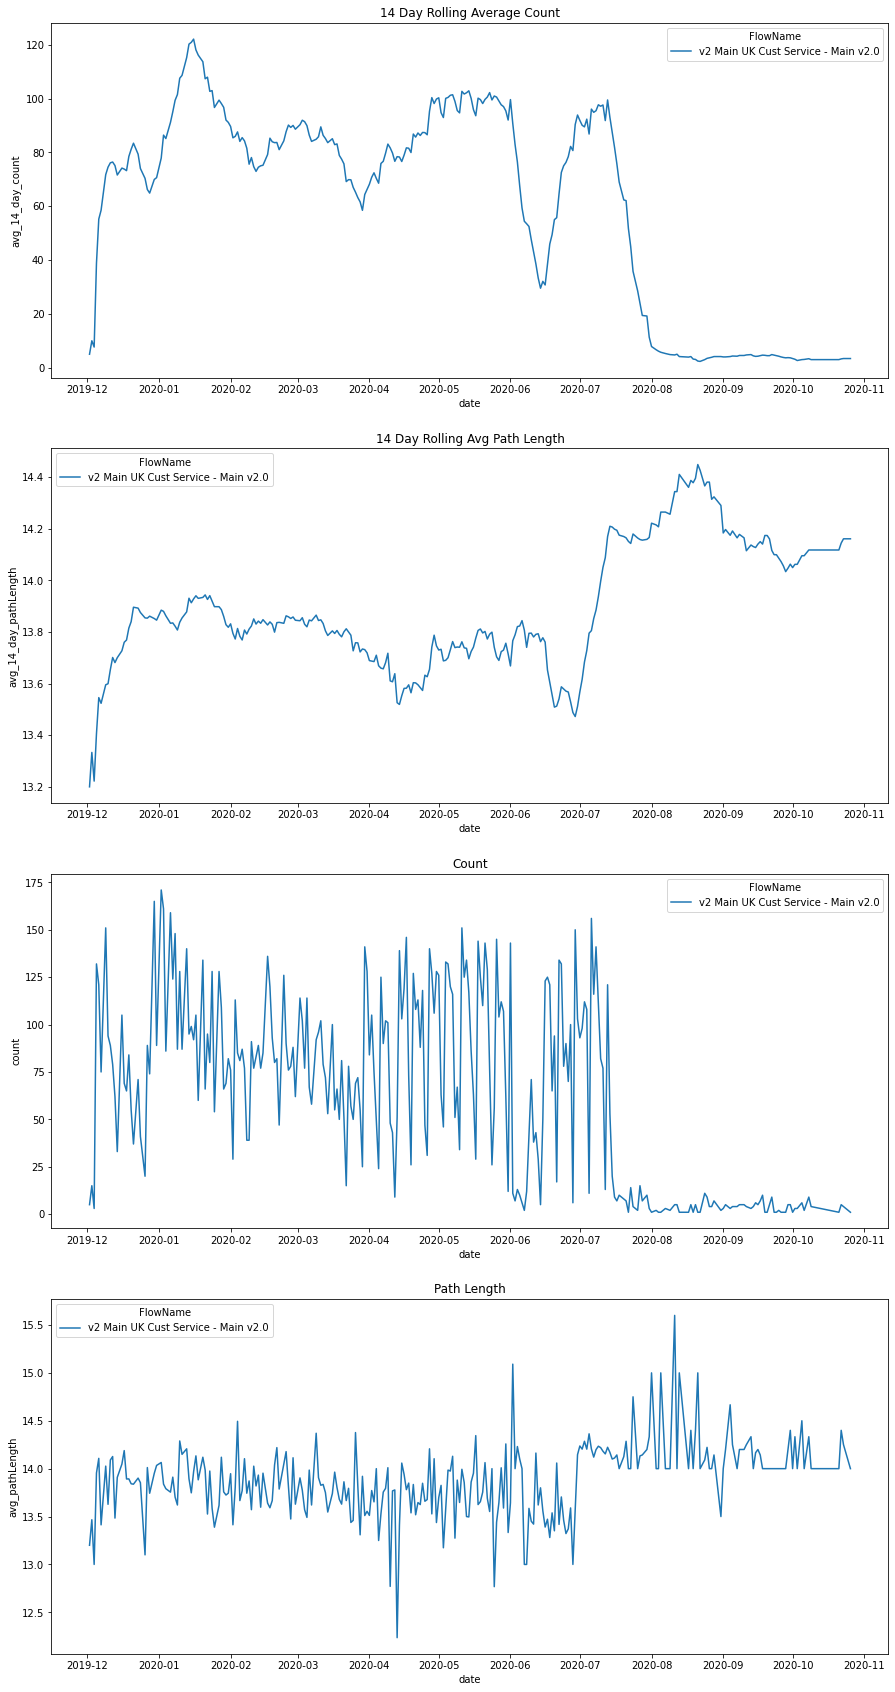

In [31]:
time_stats(f"('{FlowName}')", 'FlowName')

/home/kerri/Documents/Projects/intelepeer/sharkninja_analysis/venv8/lib/python3.8/site-packages/google/cloud/bigquery/client.py:439: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



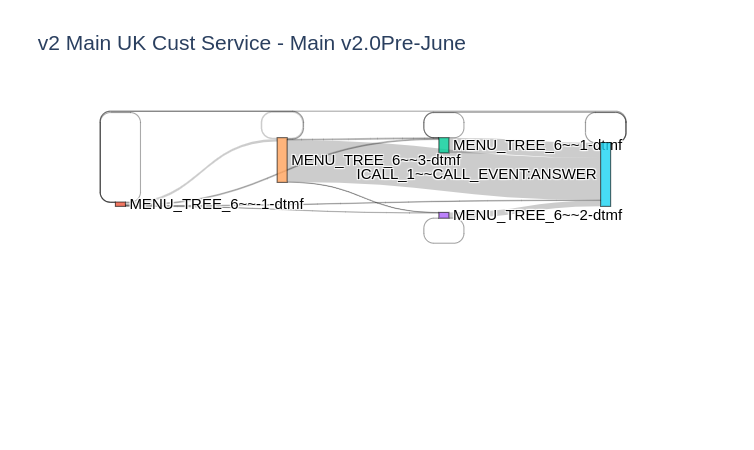

In [32]:

q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    '2020-06-01')
df = client.query(q).to_dataframe()
pre_v2_main_flow = SankeyFlow(FlowName + 'Pre-June', df)
pre_v2_main_flow.plot(0, FlowName + 'Pre-June').show()

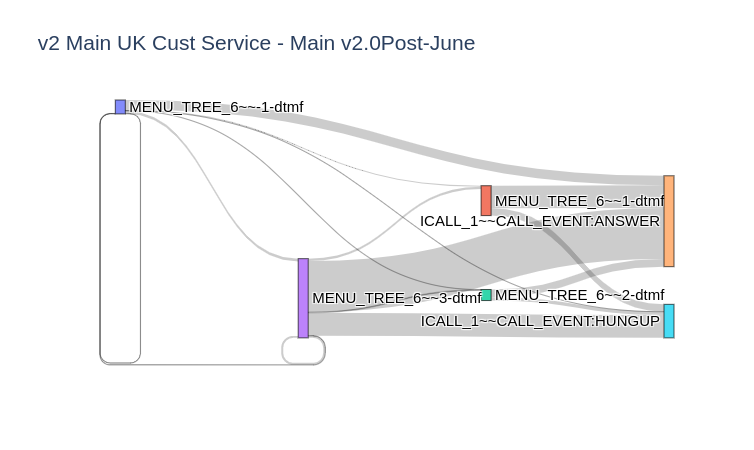

In [33]:

q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
post_v2_main_flow = SankeyFlow(FlowName + 'Post-June', df)
post_v2_main_flow.plot(0, FlowName + 'Post-June').show()

## v2 Main UK Cust Service - Main v2.0"

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. 

The lower plots compare the show the flow over two dimensions. 

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

## Takeaways
- Steep drop in volume around the 1st of July
- After the drop in volume users clearly started a different / longer path (about 1 extra step)

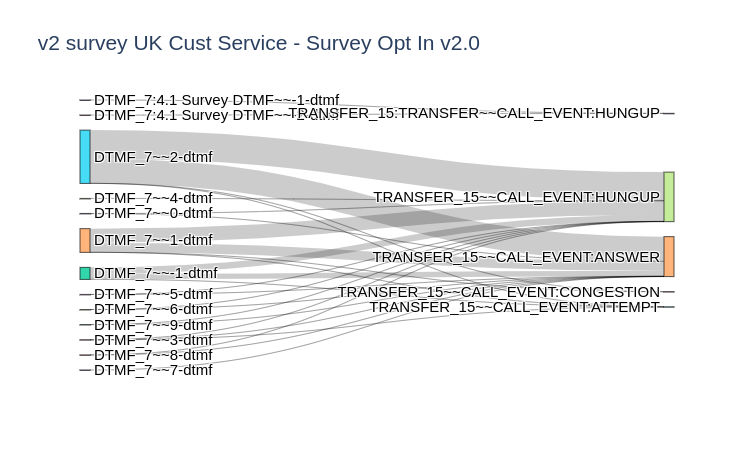

In [34]:
FlowName = "v2 survey UK Cust Service - Survey Opt In v2.0"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
v2_survey_flow = SankeyFlow(FlowName, df)
v2_survey_flow.plot(0, FlowName).show()

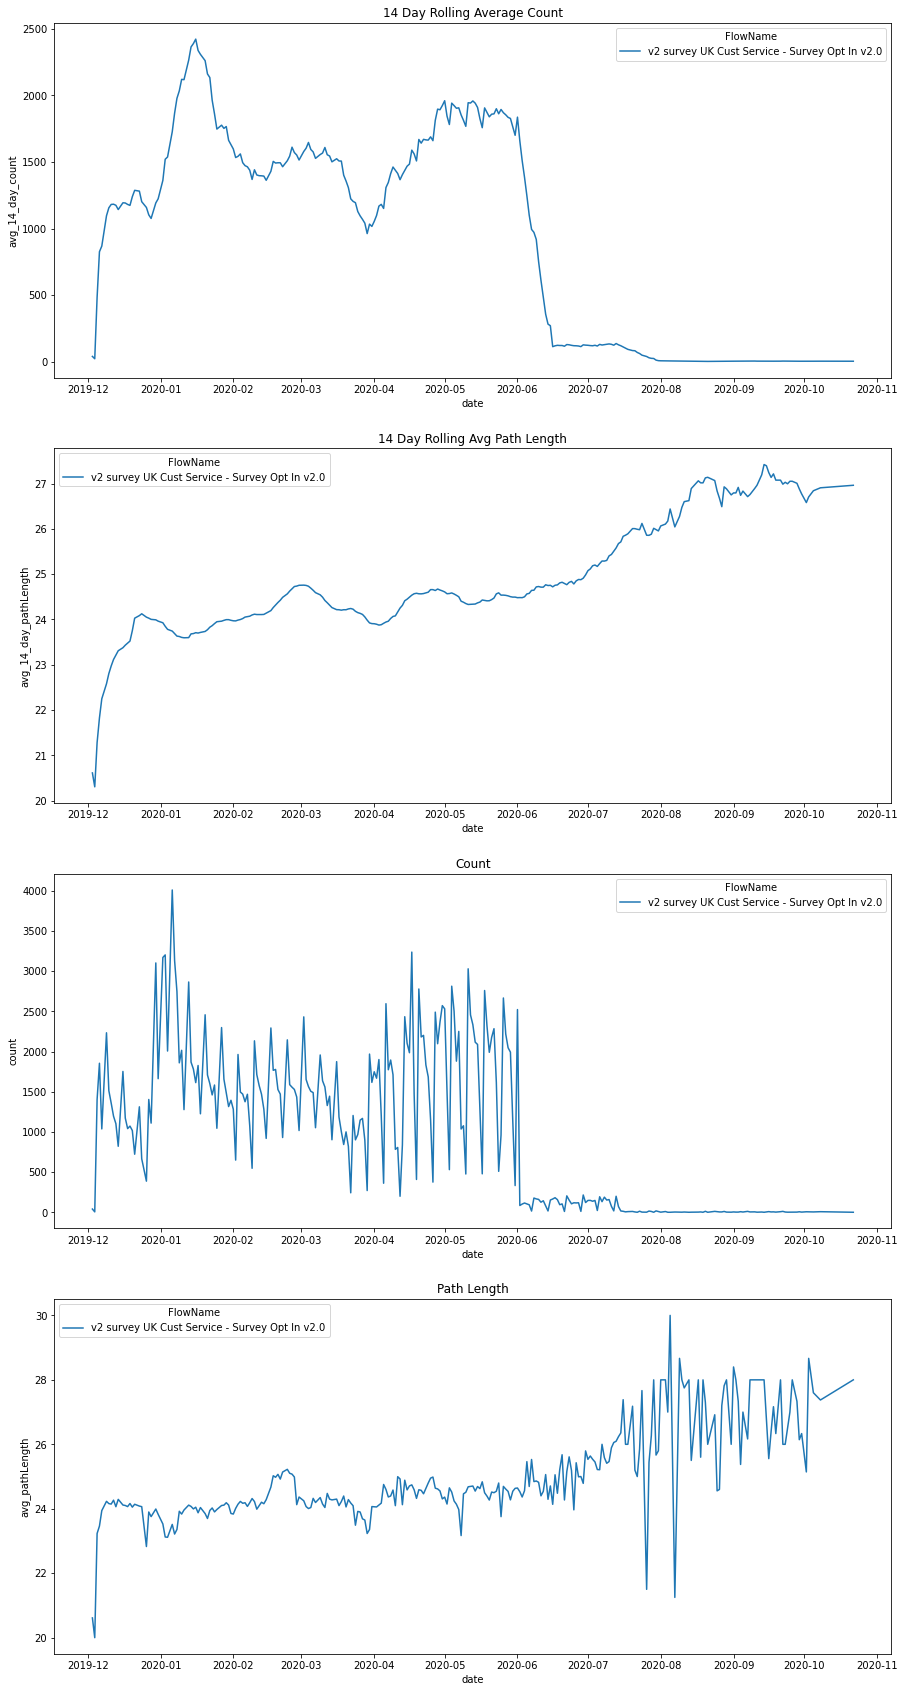

In [35]:
time_stats(f"('{FlowName}')", 'FlowName')

/home/kerri/Documents/Projects/intelepeer/sharkninja_analysis/venv8/lib/python3.8/site-packages/google/cloud/bigquery/client.py:439: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



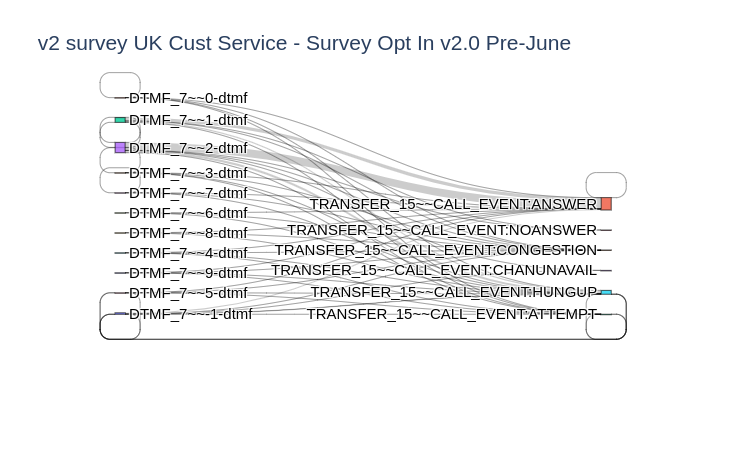

In [36]:
q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    '2020-06-01')
df = client.query(q).to_dataframe()
pre_v2_survey_flow = SankeyFlow(FlowName + 'Pre-June', df)
pre_v2_survey_flow.plot(0, FlowName + ' Pre-June').show()

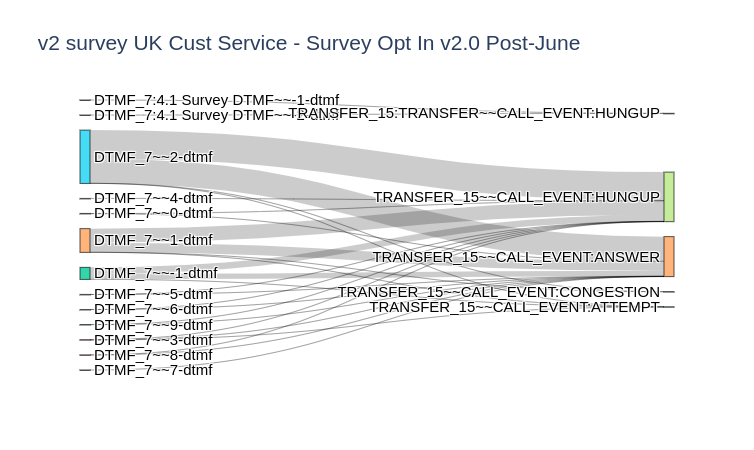

In [38]:
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
post_v2_survey_flow = SankeyFlow(FlowName + ' Post-June', df)
post_v2_survey_flow.plot(0, FlowName + ' Post-June').show()

## v2 survey UK Cust Service - Survey Opt In v2.0

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. 

The lower plots compare the show the flow over two dimensions. 

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

## Takeaways
- Steep drop in volume around the 1st of July
- After the drop in volume users gradually started a different / longer path (about 2 extra steps)
- All users move from the DTMF_7 menu to either an ICALL_1:ANSWER or ICALL_1:HANGUP

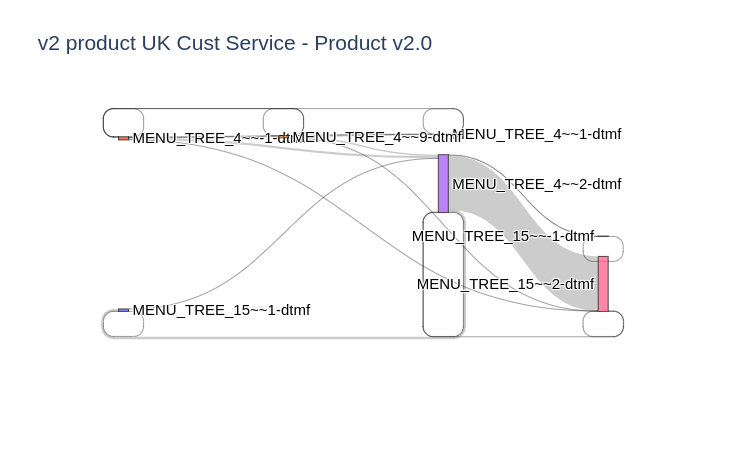

In [39]:
FlowName = "v2 product UK Cust Service - Product v2.0"
q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
v2_product = SankeyFlow(FlowName, df)
v2_product.plot(0, FlowName).show()

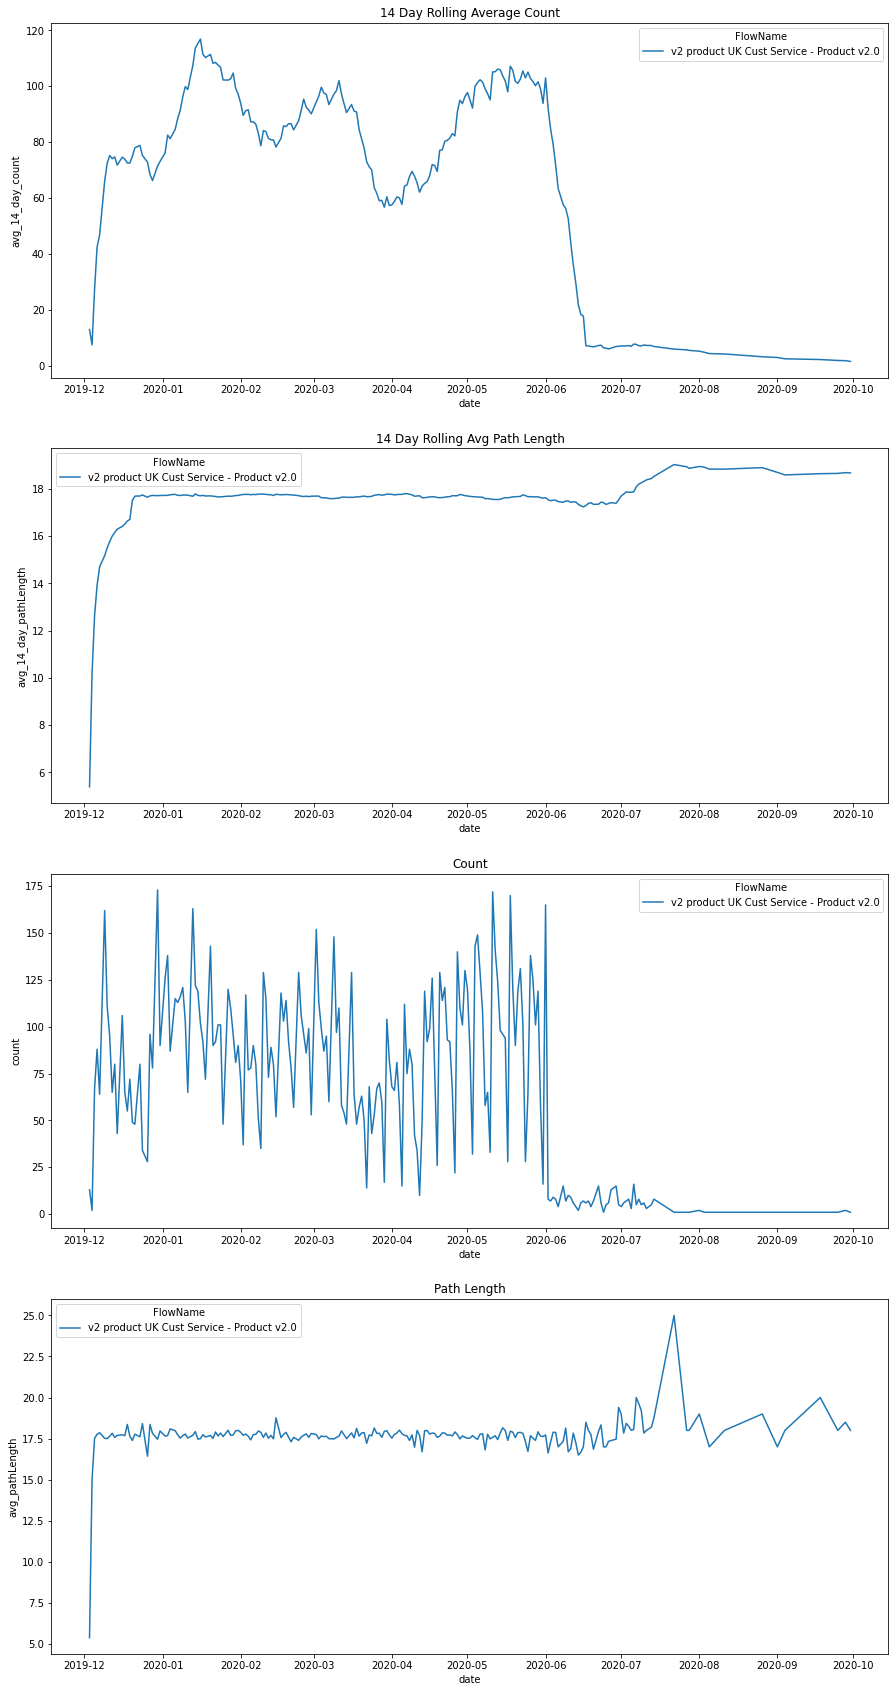

In [40]:
time_stats(f"('{FlowName}')", 'FlowName')

/home/kerri/Documents/Projects/intelepeer/sharkninja_analysis/venv8/lib/python3.8/site-packages/google/cloud/bigquery/client.py:439: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



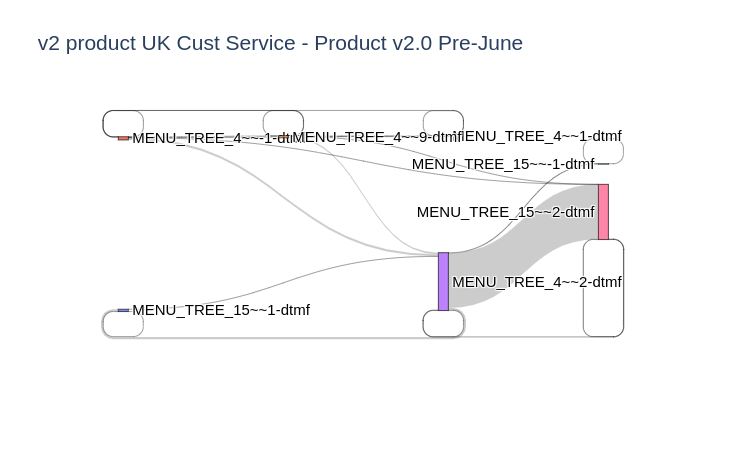

In [41]:
q = sql_temp.format(f"('{FlowName}')",
                    '2020-01-01',
                    '2020-06-01')
df = client.query(q).to_dataframe()
pre_v2_product_flow = SankeyFlow(FlowName + 'Pre-June', df)
pre_v2_product_flow.plot(0, FlowName + ' Pre-June').show()

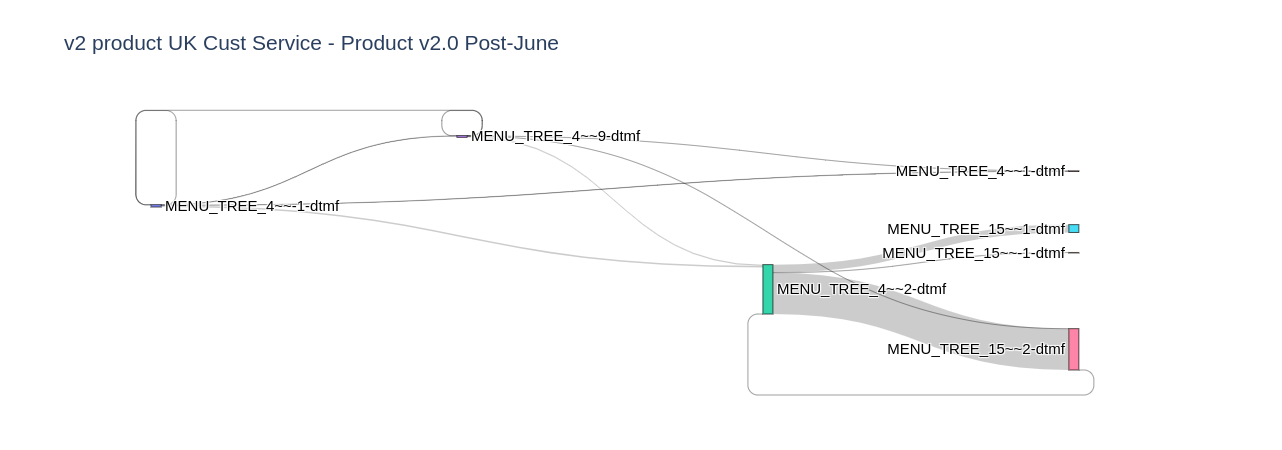

In [42]:
q = sql_temp.format(f"('{FlowName}')",
                    '2020-06-01',
                    datetime.datetime.now().strftime('%Y-%m-%d'))
df = client.query(q).to_dataframe()
post_v2_product_flow = SankeyFlow(FlowName + 'Post-June', df)
post_v2_product_flow.plot(0, FlowName + ' Post-June').show()

## v2 product UK Cust Service - Product v2.0

The upper plot shows all shows all the plots that a SessionId has taken through the flow from June 1st to today. 

The lower plots compare the show the flow over two dimensions. 

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

## Takeaways
- Steep drop in volume around the mid June
- After the drop in volume users WAS NOT a different / longer path taken by users
- Majority of users move from MENU_TREE_4-Option2 to MENU_TREE_15-Option2

In [18]:
import chart_studio.plotly as py
import chart_studio
import plotly

chart_studio.tools.set_credentials_file(username='kerri_jaya', api_key='pMY9gMxFv3QNRFBSfiV1')

347799


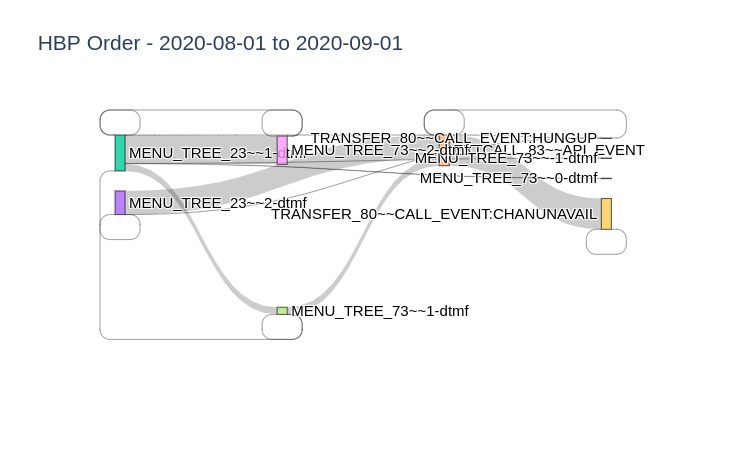

In [24]:
FlowName = "HBP Order"
start_date = '2020-08-01'
end_date = '2020-09-01'
q = sql_temp.format(f"('{FlowName}')",
                    start_date,
                    end_date)

df = client.query(q).to_dataframe()
print(len(df))
hbp_flow = SankeyFlow(FlowName, df)
fig = hbp_flow.plot(0, f"{FlowName} - {start_date} to {end_date}")
py.iplot(fig, filename=f"{FlowName} - {start_date} to {end_date}")
fig.show()

345765


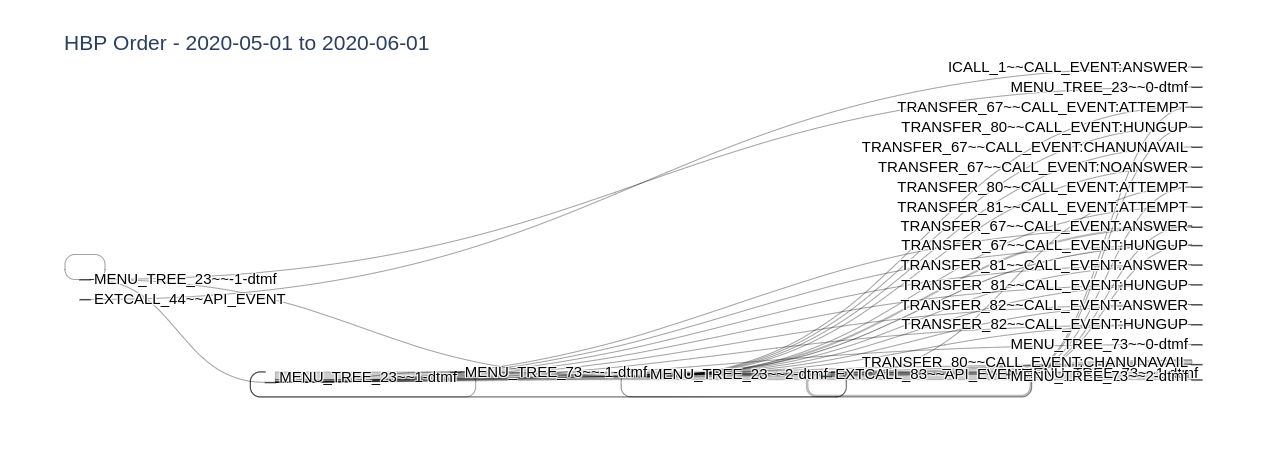

In [25]:
FlowName = "HBP Order"
start_date = '2020-05-01'
end_date = '2020-06-01'
q = sql_temp.format(f"('{FlowName}')",
                    start_date,
                    end_date)

df = client.query(q).to_dataframe()
print(len(df))
hbp_flow = SankeyFlow(FlowName, df)
fig = hbp_flow.plot(0, f"{FlowName} - {start_date} to {end_date}")
py.iplot(fig, filename=f"{FlowName} - {start_date} to {end_date}")
fig.show()

387293


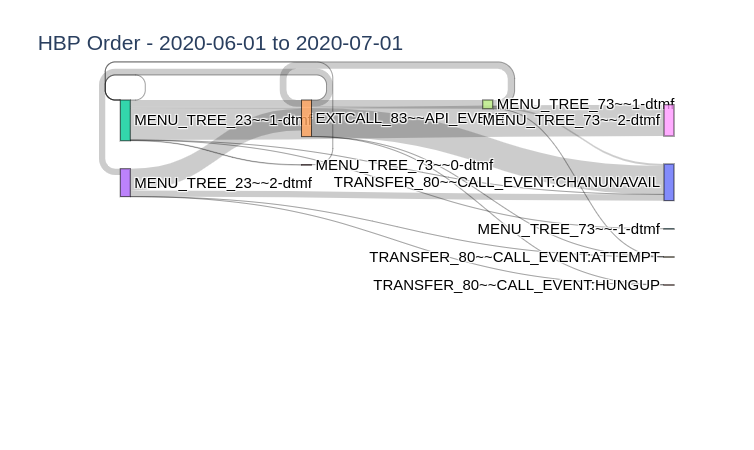

In [26]:
FlowName = "HBP Order"
start_date = '2020-06-01'
end_date = '2020-07-01'
q = sql_temp.format(f"('{FlowName}')",
                    start_date,
                    end_date)

df = client.query(q).to_dataframe()
print(len(df))
hbp_flow = SankeyFlow(FlowName, df)
fig = hbp_flow.plot(0, f"{FlowName} - {start_date} to {end_date}")
py.iplot(fig, filename=f"{FlowName} - {start_date} to {end_date}")
fig.show()

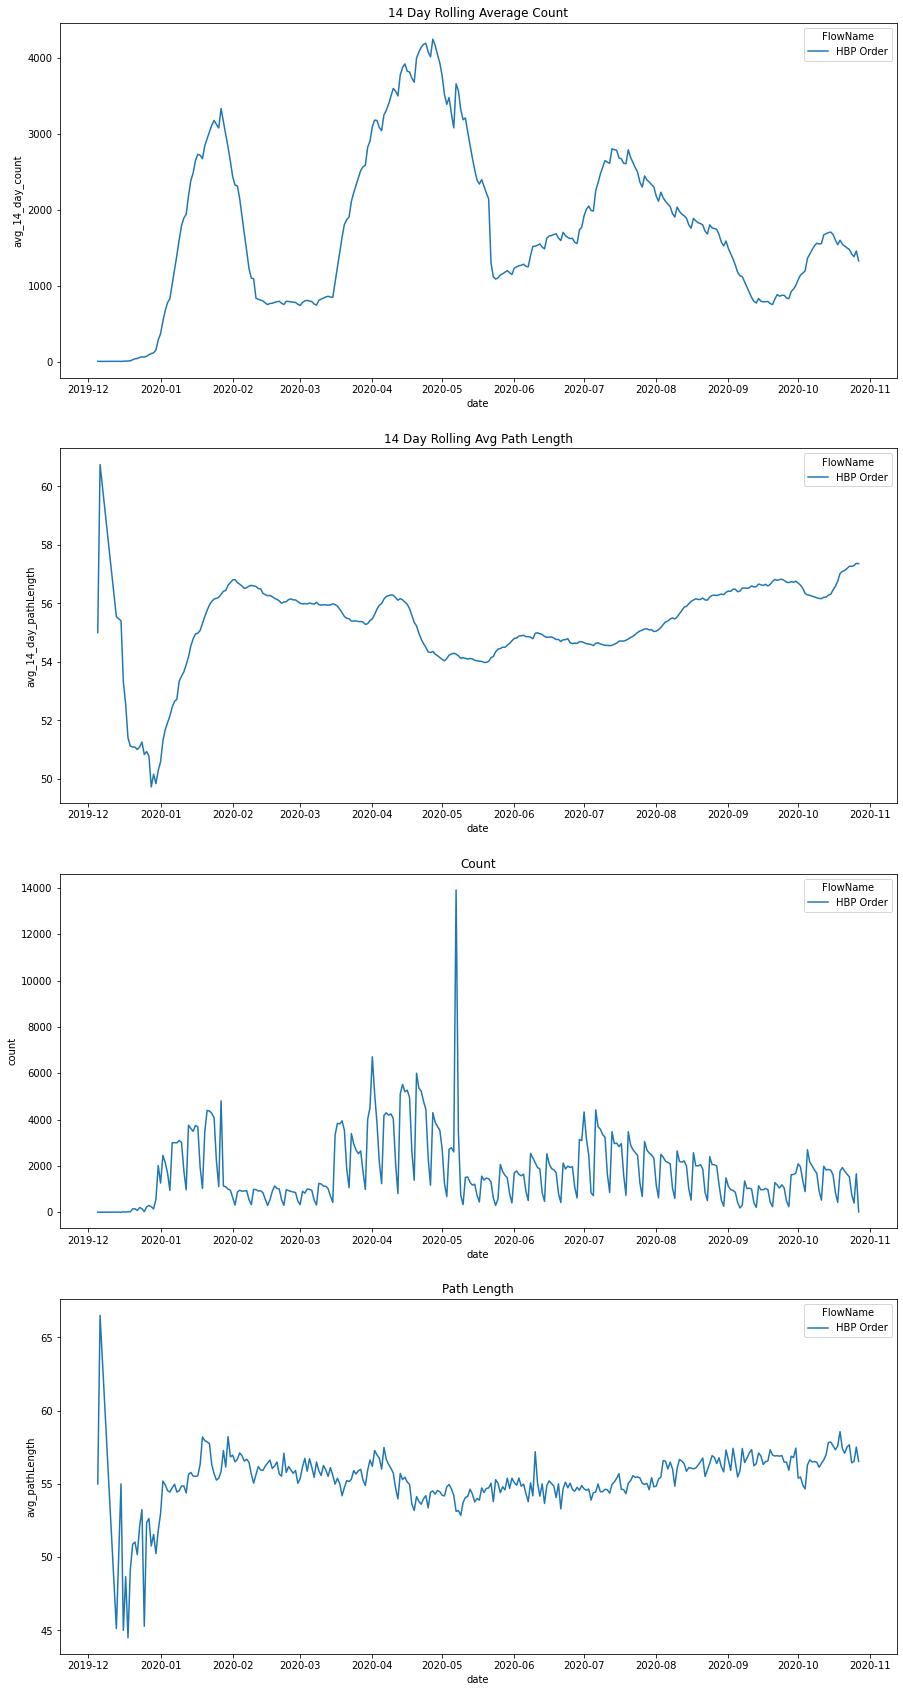

In [16]:

time_stats(f"('{FlowName}')", 'FlowName')